In [1]:
import trenchripper as tr
import anndata
import urllib.request
import os
import glob
import h5py
import shutil

import numpy as np
import pandas as pd
import seaborn as sns
import colorcet as cc
import scanpy as sc
import matplotlib as mpl
import dask.dataframe as dd
import pickle as pkl
import sklearn as skl
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import scipy.cluster.hierarchy as schQ

from dna_features_viewer import BiopythonTranslator
from Bio.SeqFeature import SeqFeature,FeatureLocation
from Bio import SeqIO
from scipy.stats import gaussian_kde
from scipy.spatial import ConvexHull

import goatools
import goatools.base
from goatools.base import download_go_basic_obo

from goatools.obo_parser import GODag
from goatools.anno.gaf_reader import GafReader
from goatools.semantic import semantic_similarity
from goatools.semantic import TermCounts, get_info_content

from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS
from goatools.go_enrichment import GOEnrichmentStudy

dask_wd = "/home/de64/scratch/de64/dask"

## Load Functions

In [58]:
def search_go(ns2assoc, obodag, inv_gene_to_id, go_term):
    namespace_abbv = {"biological_process":"BP","molecular_function":"MF","cellular_component":"CC"}
    
    print("Searching for " + str(obodag[go_term].name))
    namespace = namespace_abbv[obodag[go_term].namespace]
    child_goterms = list(obodag[go_term].get_all_children())
    gene_list = [inv_gene_to_id[key] for key,val in ns2assoc[namespace].items() if go_term in val]
    for child_goterm in child_goterms:    
        gene_list += [inv_gene_to_id[key] for key,val in ns2assoc[namespace].items() if child_goterm in val]
    gene_list = sorted(list(set(gene_list)))
    return gene_list

## Load Data

In [27]:
timeseries_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Imaging/Clustering/2023-01-23_sgRNA_Timeseries_df.pkl")
clustering_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Imaging/Clustering/Pandas_Dataframe.pkl")
clustering_an_df = anndata.read_h5ad("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE20_Imaging/Clustering/AnnData_wSteadyState.h5ad")
clustering_an_df.obs.index = clustering_an_df.obs.index.astype(int)

## add values at 8 hours
kernel_label_list = ['Kernel Trace: Delta time (s)','Kernel Trace: Septum Displacement Length Normalized','Kernel Trace: Length',\
'Kernel Trace: Width','Kernel Trace: mCherry mean_intensity','Kernel Trace: Instantaneous Growth Rate: Volume']
final_kernel_label_list = ['8 Hours: Kernel Trace: Delta time (hr)','8 Hours: Kernel Trace: Septum Displacement Length Normalized',\
 '8 Hours: Kernel Trace: Length','8 Hours: Kernel Trace: Width','8 Hours: Kernel Trace: mCherry mean_intensity',\
 '8 Hours: Kernel Trace: Instantaneous Growth Rate: Volume']

for kernel_label in kernel_label_list:
    clustering_df["8 Hours: " + kernel_label] = clustering_df[kernel_label].apply(lambda x: x[19])
    timeseries_df["8 Hours: " + kernel_label] = timeseries_df[kernel_label].apply(lambda x: x[19])

clustering_df['8 Hours: Kernel Trace: Delta time (hr)'] = clustering_df['8 Hours: Kernel Trace: Delta time (s)']/3600 #adjust interdivision units
clustering_df['8 Hours: Kernel Trace: Instantaneous Growth Rate: Volume'] = clustering_df['8 Hours: Kernel Trace: Instantaneous Growth Rate: Volume']/np.log(2) #adjust exponential units
timeseries_df['8 Hours: Kernel Trace: Delta time (hr)'] = timeseries_df['8 Hours: Kernel Trace: Delta time (s)']/3600 #adjust interdivision units
timeseries_df['8 Hours: Kernel Trace: Instantaneous Growth Rate: Volume'] = timeseries_df['8 Hours: Kernel Trace: Instantaneous Growth Rate: Volume']/np.log(2) #adjust exponential units

## add cluster coloring
cluster_levels = ["L0","L1","L2","L3"]
cluster_resolutions = [0.2,0.5,1.0,2.0]

umap_fig_df = clustering_an_df.obs.copy()[cluster_levels]
umap_fig_df["X Coord"] = clustering_an_df.obsm['X_umap'][:,0]
umap_fig_df["Y Coord"] = clustering_an_df.obsm['X_umap'][:,1]
umap_fig_df.index = umap_fig_df.index.astype(int)
umap_fig_df = umap_fig_df.join(clustering_df.drop(columns=cluster_levels),on="oDEPool7_id")

for cluster_level in cluster_levels:
    all_clusters = list(umap_fig_df[cluster_level].unique())
    colors = cc.glasbey_hv[:len(all_clusters)]
    # Create a dictionary mapping each category to a color
    reorder_cluster_dict = {cluster:i for i,cluster in enumerate(all_clusters)}
    color_dict = dict(zip(all_clusters, colors))
    umap_fig_df[cluster_level + " Color"] = umap_fig_df[cluster_level].astype(str).apply(lambda x: color_dict[x])

control_df = timeseries_df[timeseries_df["Category"].isin(['OnlyPlasmid', 'NoTarget'])]

/home/de64/micromamba/envs/crispri/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [57]:
# Get ontologies
obo_fname = download_go_basic_obo()

# Get ecoli association file (ecocyc)
gaf_handle = goatools.base.http_get("http://current.geneontology.org/annotations/ecocyc.gaf.gz",fout="./ecocyc.gaf.gz")
gaf_fname = goatools.base.gunzip("./ecocyc.gaf.gz")

## Getting ontologies and other nonesense

obodag = GODag(obo_fname)
objanno = GafReader(gaf_fname)
ns2assoc = objanno.get_ns2assc()

gene_to_id = {assoc.DB_Symbol:assoc.DB_ID for assoc in objanno.associations}
inv_gene_to_id = {assoc.DB_ID:assoc.DB_Symbol for assoc in objanno.associations}
synonym_dict = {synonym:assoc.DB_ID for assoc in objanno.associations for synonym in assoc.DB_Synonym}
gene_to_id.update(synonym_dict)

  EXISTS: go-basic.obo
requests.get(http://current.geneontology.org/annotations/ecocyc.gaf.gz, stream=True)
  WROTE: ./ecocyc.gaf.gz

go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms
HMS:0:00:00.567076  58,540 annotations READ: ./ecocyc.gaf 


## Figure S7A

In [28]:
title_list = ["Interdivision Time (hr)","Septum Displacement/Length","Length $(\mu m)$","Width $(\mu m)$",\
              "mKate2 Mean Intensity (AU)","Growth Rate (1/hr)"]
hist_ranges = [(0,2),(0,0.12),(0,12),(1.1,1.5),(0,8000),(0,2)]
hist_ticks = [[0.,0.5,1.0,1.5,2.0],[0.,0.05,0.1],[0,3,6,9,12],[1.1,1.2,1.3,1.4,1.5],\
              [0,2000,4000,6000,8000],[0.,0.5,1.0,1.5,2.]]

## set cmap range
median_vals_dict = control_df[final_kernel_label_list].median().to_dict()

min_vals = []
max_vals = []
for label in final_kernel_label_list:
    vmin,vmax = np.nanpercentile(umap_fig_df[label],5),np.nanpercentile(umap_fig_df[label],95)
    vcenter = median_vals_dict[label]
    min_deviation,max_deviation = (vcenter-vmin,vmax-vcenter)
    if min_deviation>max_deviation:
        vmax = vcenter + min_deviation
    else:
        vmin = vcenter - max_deviation
    min_vals.append(vmin)
    max_vals.append(vmax)

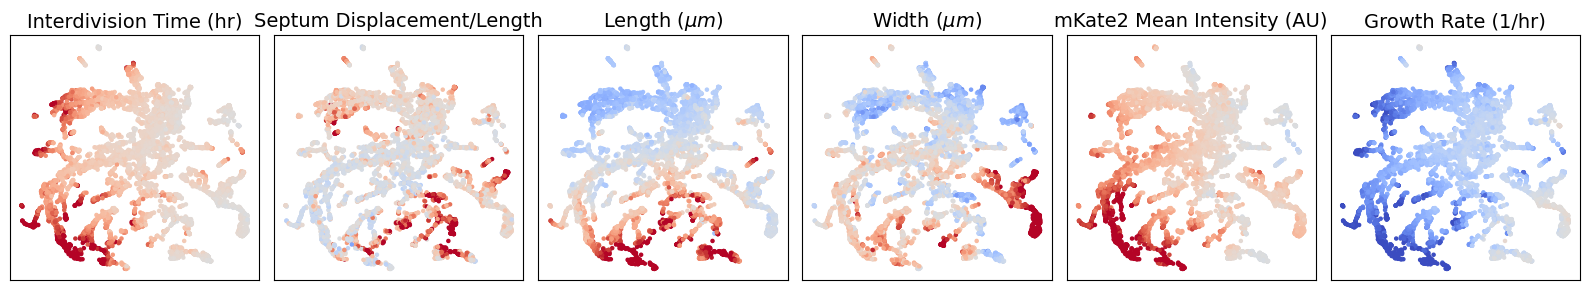

In [29]:
fig = plt.figure(figsize=(16,3))
# fig, axs = plt.subplots(2,3,figsize=(16,11))
for i,pheno_label in enumerate(final_kernel_label_list[:6]):
    plt.subplot(1,6,i+1)
    # axs[0,i].scatter(umap_fig_df["X Coord"],umap_fig_df["Y Coord"],c=umap_fig_df[cluster_level + " Color"],s=5,zorder=1)
    plt.title(str(title_list[i]), fontsize=14)
    plt.scatter(umap_fig_df["X Coord"],umap_fig_df["Y Coord"],
                c=umap_fig_df[pheno_label],s=5,zorder=1,\
                vmin=min_vals[i],vmax=max_vals[i],cmap="coolwarm")
    plt.yticks([])
    plt.xticks([])

plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S7/Phenotypes_Dist.png",dpi=500,transparent=True,bbox_inches="tight")

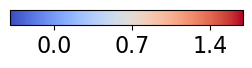

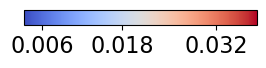

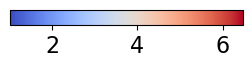

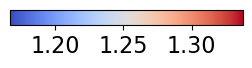

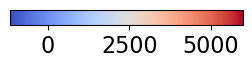

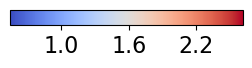

In [31]:
cbar_labels = [r'$ \tau $',r'$ L_{S} $',r'$ L $',r'$ W $',r'$ I_{rpsL} $',r'$ \lambda $']
cbar_ticks_list = [[0.,0.7,1.4],[0.006,0.018,0.032],[2,4,6],\
              [1.2,1.25,1.3],[0,2500,5000],[1.,1.6,2.2]]


for i,label in enumerate(final_kernel_label_list[:6]):
    fig = plt.figure(figsize=(3,0.2))
    ax = plt.subplot(1,1,1)
    cbar_ticks = cbar_ticks_list[i]
    # Create a colormap and a normalization object
    cmap = plt.get_cmap('coolwarm')  # or any other colormap, e.g., 'jet', 'coolwarm', 'plasma', etc.
    norm = mpl.colors.Normalize(vmin=min_vals[i], vmax=max_vals[i])  # set the range of values to normalize, e.g., 0 to 1

    # Create a ScalarMappable object
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # this line is needed to create the ScalarMappable object, but the array can be empty
    cbar = plt.colorbar(sm, cax=ax, orientation='horizontal',ticks=cbar_ticks)
    # ax.set_title(cbar_labels[i],fontsize=20)
    cbar.ax.tick_params(labelsize=16)
    ax.yaxis.set_ticks_position('right')
    # axes[i//2,i%2].set_yticklabels(axes[i//2,i%2].get_yticklabels(),fontsize=0)
    # plt.tight_layout()
    plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S7/" + str(title_list[i].split(" ")[0]) +"_Cbar.png",dpi=500,transparent=True,bbox_inches="tight")
    plt.show()

## Figure S7B

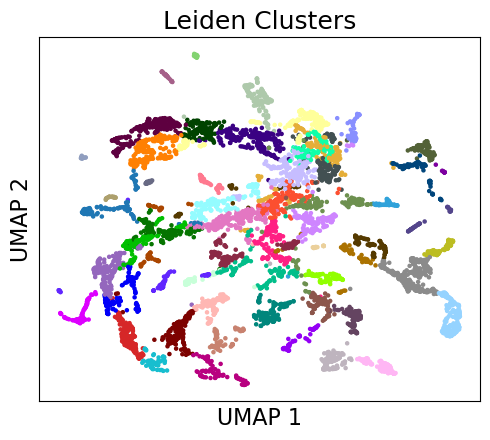

In [48]:
fig = plt.figure(figsize=(5,4.5))

ax = plt.subplot(1,1,1)
ax.scatter(umap_fig_df["X Coord"],umap_fig_df["Y Coord"],c=umap_fig_df["L3 Color"],s=5,zorder=1)

ax.set_xticks([])  # Remove x-axis ticks
ax.set_yticks([])  # Remove y-axis ticks

plt.title("Leiden Clusters",fontsize=18)
plt.xlabel('UMAP 1',fontsize=16)
plt.ylabel('UMAP 2',fontsize=16)

plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S7/UMAP_Clusters.png",dpi=500,transparent=True,bbox_inches="tight")

## Figure S7C

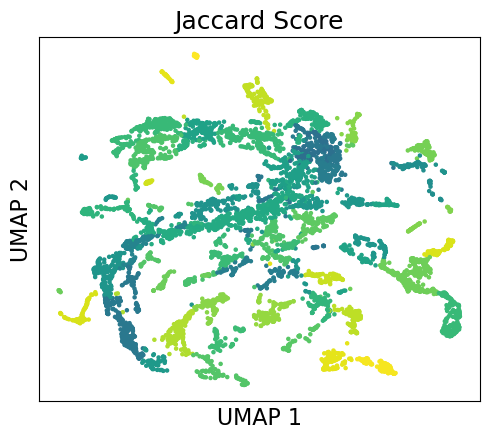

In [52]:
fig = plt.figure(figsize=(5,4.5))

ax = plt.subplot(1,1,1)
ax.scatter(umap_fig_df["X Coord"],umap_fig_df["Y Coord"],c=umap_fig_df["L3 Jackknife Jaccard"],s=5,zorder=1,vmin=0,vmax=1)

ax.set_xticks([])  # Remove x-axis ticks
ax.set_yticks([])  # Remove y-axis ticks

plt.title("Jaccard Score",fontsize=18)
plt.xlabel('UMAP 1',fontsize=16)
plt.ylabel('UMAP 2',fontsize=16)

plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S7/UMAP_Jaccard.png",dpi=500,transparent=True,bbox_inches="tight")

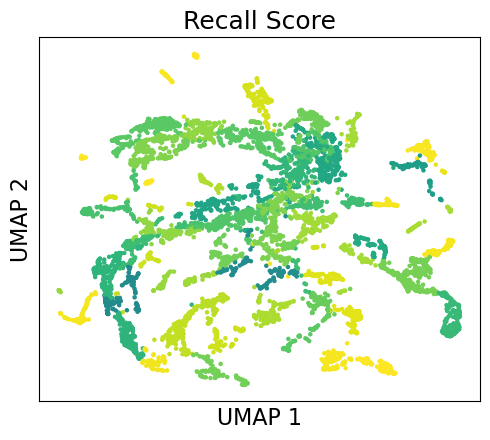

In [53]:
fig = plt.figure(figsize=(5,4.5))

ax = plt.subplot(1,1,1)
ax.scatter(umap_fig_df["X Coord"],umap_fig_df["Y Coord"],c=umap_fig_df["L3 Jackknife Recall"],s=5,zorder=1,vmin=0,vmax=1)

ax.set_xticks([])  # Remove x-axis ticks
ax.set_yticks([])  # Remove y-axis ticks

plt.title("Recall Score",fontsize=18)
plt.xlabel('UMAP 1',fontsize=16)
plt.ylabel('UMAP 2',fontsize=16)

plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S7/UMAP_Recall.png",dpi=500,transparent=True,bbox_inches="tight")

/tmp/ipykernel_22898/2164500502.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(ticklabels=[0.,0.2,0.4,0.6,0.8,1.0],fontsize=16)


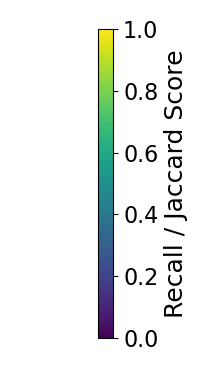

In [54]:
cbarfig, cbarax = plt.subplots(1,1,figsize=(2,4))
# Remove the axes' elements
cbarax.axis('off')
# Create a colorbar
cbar = cbarfig.colorbar(scatterout, ax=cbarax)
# Optionally, set the label for the colorbar
cbar.set_label('Recall / Jaccard Score', fontsize=18)
cbar.set_ticklabels(ticklabels=[0.,0.2,0.4,0.6,0.8,1.0],fontsize=16)
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S7/Cbar.png",dpi=500,transparent=True,bbox_inches="tight")

## Figure S7D

In [59]:
gene_highlight_map = {False:"lightgrey", True:"red"}
divisome_genes = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:1990586")
ribosomal_proteins = sorted(umap_fig_df[umap_fig_df["Gene"].apply(lambda x: ("rps" in x)|("rpm" in x)|("rpl" in x))]["Gene"].unique())
tRNA_aminoacylation_genes = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0043039")
replication_initiation  = ["dnaA","dnaB","dnaC","dnaG"]
replisome  = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0009360")
pg_synthesis  = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0009252")
chr_segregation  = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0007059")
lipoprotein_transport  = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0042953")
lipid_a_synthesis  = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0009245")
fatty_acid_synthesis  = search_go(ns2assoc, obodag, inv_gene_to_id, "GO:0006633")


gene_groups = [divisome_genes,ribosomal_proteins,tRNA_aminoacylation_genes,\
              replication_initiation,replisome,pg_synthesis,\
              chr_segregation,lipoprotein_transport,lipid_a_synthesis,\
              fatty_acid_synthesis]
gene_titles = ["Divisome","Ribosomal Proteins","tRNA Synthetases",\
              "Replication Initiation","Replisome","PG Synthesis",\
              "Chromosome Segregation","Lipoprotein Transport","Lipid A Synthesis",\
              "Fatty Acid Synthesis"]

Searching for divisome complex
Searching for tRNA aminoacylation
Searching for DNA polymerase III complex
Searching for peptidoglycan biosynthetic process
Searching for chromosome segregation
Searching for lipoprotein transport
Searching for lipid A biosynthetic process
Searching for fatty acid biosynthetic process


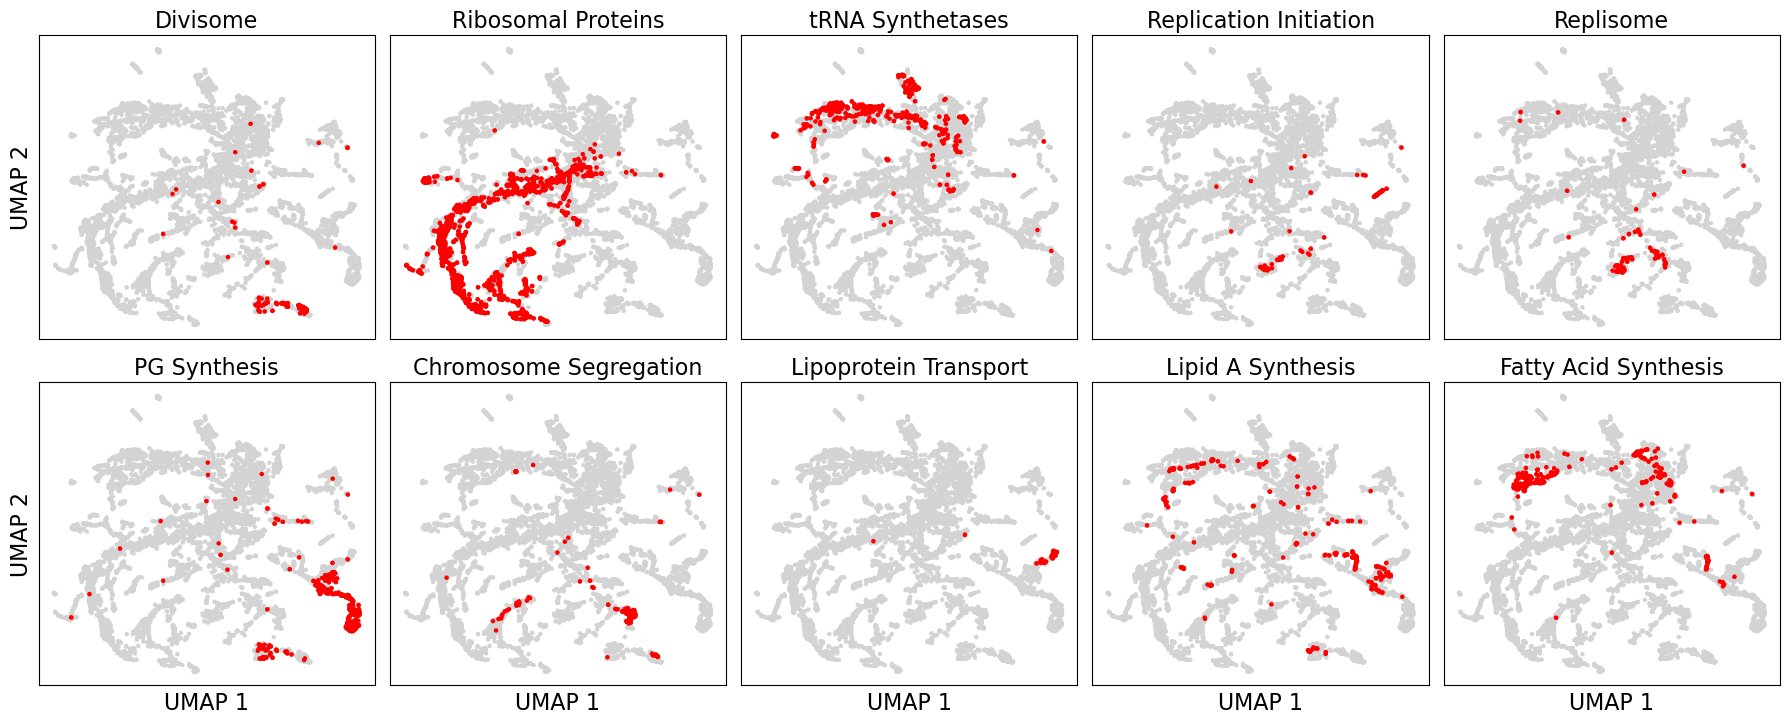

In [63]:
fig = plt.figure(figsize=(18,14))
for i in range(len(gene_groups)):
    ax = plt.subplot(4,5,i+1)
    umap_fig_df["Highlight Gene"] = umap_fig_df["Gene"].isin(gene_groups[i])
    
    ax.scatter(umap_fig_df["X Coord"],umap_fig_df["Y Coord"],\
                c=umap_fig_df["Highlight Gene"].apply(lambda x: gene_highlight_map[x]),\
                s=5,zorder=1)
    ax.scatter(umap_fig_df[umap_fig_df["Highlight Gene"]]["X Coord"],umap_fig_df[umap_fig_df["Highlight Gene"]]["Y Coord"],\
                c=umap_fig_df[umap_fig_df["Highlight Gene"]]["Highlight Gene"].apply(lambda x: gene_highlight_map[x]),\
                s=5,zorder=1)
    ax.set_title(gene_titles[i], fontsize=16)
    if i%5 == 0:
        ax.set_ylabel("UMAP 2", fontsize=16)
    else:
        ax.set_ylabel("", fontsize=16)
    if i<5:
        ax.set_xlabel("", fontsize=16)
    else:
        ax.set_xlabel("UMAP 1", fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S7/UMAP_GO_Categories_Panel_A.png",dpi=500,transparent=True,bbox_inches="tight")

## Figure S7E

In [64]:
gene_highlight_map = {False:"lightgrey", True:"red"}


topA_genes = ["topA"]
hisS_genes = ["hisS","sroE"]
rnb_genes = ["rnb"]
leuS_genes = ["leuS"]
csrA_genes = ["csrA"]

gene_groups = [topA_genes,hisS_genes,rnb_genes,\
              leuS_genes,csrA_genes]
gene_titles = ["topA","sroE-hisS","rnb",\
              "leuS","csrA"]

gene_groups_majority_clusters = [umap_fig_df[umap_fig_df["Gene"].isin(gene_group)]["L3"].value_counts().index[0] for gene_group in gene_groups]

0.9473684210526315
0.4666666666666667
0.8571428571428571
0.7241379310344828
0.925


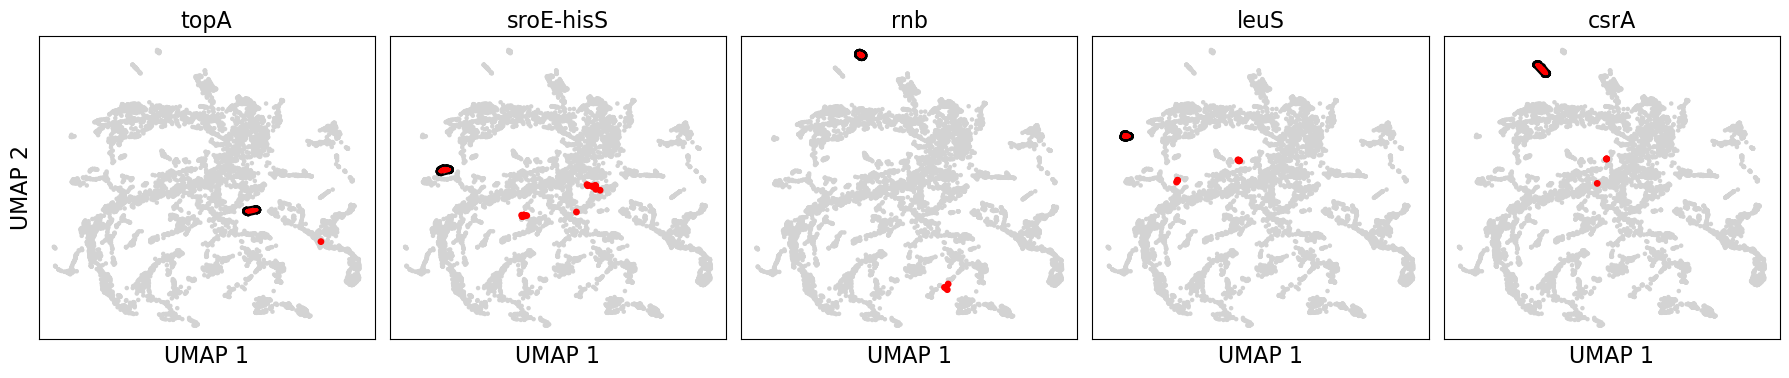

In [67]:
fig = plt.figure(figsize=(18,14))
for i in range(len(gene_groups)):
    ax = plt.subplot(4,5,i+1)
    umap_fig_df["Highlight Gene"] = umap_fig_df["Gene"].isin(gene_groups[i])
    umap_fig_df["Highlight Cluster"] = umap_fig_df["L3"].isin([gene_groups_majority_clusters[i]])
    
    ax.scatter(umap_fig_df["X Coord"],umap_fig_df["Y Coord"],\
                c=umap_fig_df["Highlight Gene"].apply(lambda x: gene_highlight_map[x]),\
                s=5,zorder=1)
    ax.scatter(umap_fig_df[umap_fig_df["Highlight Gene"]]["X Coord"],umap_fig_df[umap_fig_df["Highlight Gene"]]["Y Coord"],\
                c=umap_fig_df[umap_fig_df["Highlight Gene"]]["Highlight Gene"].apply(lambda x: gene_highlight_map[x]),\
                s=15, zorder=1)


    cluster_points_x,cluster_points_y = umap_fig_df[umap_fig_df["Highlight Cluster"]]["X Coord"].values,umap_fig_df[umap_fig_df["Highlight Cluster"]]["Y Coord"].values
    cluster_position_arr = np.stack([cluster_points_x,cluster_points_y]).T

    # Draw perimeters
    marker_size = 2.5
    angles = np.linspace(0, 2 * np.pi, 100)
    all_perimeter_x,all_perimeter_y = [],[]
    for xi, yi in zip(cluster_points_x, cluster_points_y):
        # Convert size to radius
        radius = np.sqrt(marker_size / np.pi)  # Adjust for scaling
        perimeter_x = xi + radius * np.cos(angles)
        perimeter_y = yi + radius * np.sin(angles)
        all_perimeter_x.append(perimeter_x)
        all_perimeter_y.append(perimeter_y)

    all_perimeter_x,all_perimeter_y=np.concatenate(all_perimeter_x),np.concatenate(all_perimeter_y)
    # Stack perimeter points and compute convex hull
    perimeter_points = np.stack([all_perimeter_x, all_perimeter_y], axis=1)
    hull = ConvexHull(perimeter_points)
    # Plot convex hull
    for simplex in hull.simplices:
        plt.plot(perimeter_points[simplex, 0], perimeter_points[simplex, 1], 'black', linewidth=1.5)  # Hull in blue

    # ax.scatter(umap_fig_df[umap_fig_df["Highlight Cluster"]]["X Coord"],umap_fig_df[umap_fig_df["Highlight Cluster"]]["Y Coord"],\
    #             s=15, zorder=10, edgecolor='blue', facecolor='none', linewidth=1.5)
    print(np.sum(umap_fig_df["Highlight Cluster"])/np.sum(umap_fig_df["Highlight Gene"]))
    ax.set_title(gene_titles[i], fontsize=16)
    if i%5 == 0:
        ax.set_ylabel("UMAP 2", fontsize=16)
    else:
        ax.set_ylabel("", fontsize=16)
    ax.set_xlabel("UMAP 1", fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S7/UMAP_GO_Categories_Panel_B.png",dpi=500,transparent=True,bbox_inches="tight")

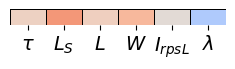

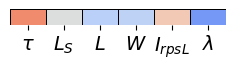

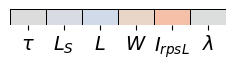

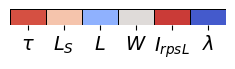

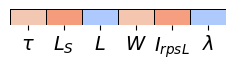

In [69]:
for i,cluster in enumerate(gene_groups_majority_clusters):
    
    select_gene_df_clusters = umap_fig_df[umap_fig_df["L3"]==cluster]
    select_gene_df_clusters = select_gene_df_clusters[final_kernel_label_list].mean().to_frame().T
    
    # Create a custom layout for the plots
    fig = plt.figure(figsize=(3.25,(1*0.2)))
    gs = gridspec.GridSpec(1, len(final_kernel_label_list)+1, width_ratios=[1, 1, 1, 1, 1, 1 ,1])
    for idx, label in enumerate(final_kernel_label_list):
        ax = plt.subplot(gs[idx+1])
        sns.heatmap(select_gene_df_clusters[final_kernel_label_list[idx]].values.reshape(-1,1),vmin=min_vals[idx],vmax=max_vals[idx],\
                        cmap="coolwarm",center=median_vals_dict[label],\
                       cbar=False, yticklabels=False, ax=ax,annot=False,\
                       linewidths=0.5,linecolor="black")
    
        ax.set_xticklabels(labels=[cbar_labels[idx]],fontsize=14)
    
    
    # Remove margins between subplots
    plt.subplots_adjust(wspace=0)
    plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S7/" + str(gene_titles[i]) + ".png",dpi=500,transparent=True,bbox_inches="tight")